<a href="https://colab.research.google.com/github/vincent1rookie/RL-Lab/blob/master/RBM_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
!pip install tensorboardcolab

In [0]:
"""
This script is to build a Resctricted Boltzmann Machine

"""

import tensorflow as tf
import numpy as np
from tensorboardcolab import *


class RBM_RL:

    def __init__(self, name: str, n_s: int, n_a: int,  n_h: int, learning_rate: float,
                 beta: float, gamma: float, epsilon = 0.01,
                 load_path=None, save_path=None):
        self.name = name
        self.n_s = n_s
        self.n_a = n_a
        self.n_h = n_h
        self.learning_rate = learning_rate
        self.beta = beta
        self.gamma = gamma
        self.epsilon = epsilon
        self.tbc = TensorBoardColab()
        
        tf.reset_default_graph()

        with tf.variable_scope(self.name + '_input', reuse=tf.AUTO_REUSE):
            self.s = tf.placeholder(tf.float32, [1, self.n_s], name=self.name + '_s')
            self.a = tf.placeholder(tf.float32, [1, self.n_a], name=self.name + '_a')
            self.v = tf.concat([self.s, self.a], name=self.name + '_v', axis=1)
            self.s_next = tf.placeholder(tf.float32, [1, self.n_s], name=self.name + '_s_next')
            self.a_next = tf.placeholder(tf.float32, [1, self.n_a], name=self.name + '_a_next')
            self.v_next = tf.concat([self.s, self.a], name=self.name + '_v_next', axis=1)
            self.r = tf.placeholder(tf.float32, name=self.name+'_s')

        with tf.variable_scope(self.name + '_params', reuse=tf.AUTO_REUSE):
            self.W = tf.get_variable(name=self.name + '_W', shape=[self.n_s+self.n_a, self.n_h],
                                     initializer=tf.truncated_normal_initializer(mean=0.0, stddev=1))
            tf.summary.histogram('weights', self.W)

        with tf.variable_scope(self.name + '_hidden', reuse=tf.AUTO_REUSE):
            self.h_prob = tf.sigmoid(tf.matmul(self.v, self.W), name=self.name+'_h')
            self.h_prob_next = tf.sigmoid(tf.matmul(self.v_next, self.W), name=self.name + '_h_next')
            tf.summary.histogram('h_prob', self.h_prob)

        with tf.variable_scope(self.name + '_q_value', reuse=tf.AUTO_REUSE):
#             self.Q1 = tf.matmul(tf.matmul(self.v, self.W), tf.transpose(self.h_prob))
            self.Q1 = tf.reduce_sum(tf.matmul(tf.matmul(self.v, self.W), tf.transpose(self.h_prob))) \
               - 1 / self.beta * tf.reduce_sum((self.h_prob * tf.log(self.h_prob+1e-6) + (1 - self. h_prob) * tf.log(1 - self.h_prob+1e-6)))
            self.Q2 = tf.reduce_sum(tf.matmul(tf.matmul(self.v_next, self.W), tf.transpose(self.h_prob_next))) \
               - 1 / self.beta * tf.reduce_sum((self.h_prob_next * tf.log(self.h_prob_next+1e-6) + (1 - self. h_prob_next) * tf.log(1 - self.h_prob_next+1e-6)))
#             self.Q1 = tf.reduce_sum(tf.matmul(tf.matmul(self.v, self.W), tf.transpose(self.h_prob))) 
#             self.Q2 = tf.reduce_sum(tf.matmul(tf.matmul(self.v_next, self.W), tf.transpose(self.h_prob_next))) 
            tf.summary.scalar('Q1', self.Q1)
            tf.summary.scalar('Q2', self.Q2)

    
        with tf.variable_scope(self.name + '_update', reuse=tf.AUTO_REUSE):
            self.W_delta =(self.r + self.gamma * self.Q2 - self.Q1) * tf.matmul(tf.transpose(self.v), self.h_prob) * self.learning_rate
            self.op = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
            self.train_step = self.op.apply_gradients([(-self.W_delta, self.W)])
#             self.update = self.W.assign_add(self.W_delta)
            
        self.sess = tf.Session()
        self.merged = tf.summary.merge_all()
        self.writer = self.tbc.get_writer()
        
        self.train_data = None
        self.learning_step = 0

        # Try to save and/or reload model
        self.save_path = save_path
        self.saver = tf.train.Saver()
        if load_path is not None:
            self.load_path = load_path
            self.saver.restore(self.sess, self.load_path)
        else:
            self.sess.run(tf.global_variables_initializer())

    def fit(self, s, a, s_next, r, valid):
        a_next = self.act(s_next, valid, test_mode = True)
        # self._train_step(s, a, s_next, a_next)
        _, self.rs = self.sess.run([self.train_step, self.merged], 
                      feed_dict={self.s: s, self.a: a, self.s_next: s_next, self.a_next: a_next.reshape([1, 5]), self.r: r})
#         print(self.sess.run(self.W,
#                        feed_dict={self.s: s, self.a: a, self.s_next: s_next, self.a_next: a_next.reshape([1, 5]), self.r: r}))
        self.learning_step += 1
        if self.learning_step % self.n_s == 0:
            self.epsilon += 0.05
            self.epsilon = min(self.epsilon, 0.95)
#         self.rs = self.sess.run(self.merged, feed_dict={self.s: s, self.a: a, self.s_next: s_next, self.a_next: a_next.reshape([1, 5]), self.r: r})
        self.writer.add_summary(self.rs, self.learning_step)

    def act(self, s, valid, test_mode=False):  # TODO: Need to apply epsilon-greedy method
        a = np.identity(self.n_a)
        if test_mode or (np.random.random() < self.epsilon):
            q_array = np.array(list(map(lambda x: self.sess.run(self.Q1, feed_dict={self.s: s, self.a: x.reshape([1,5])}), a)))
        else:
            q_array = np.random.random(5)
        a_next = np.nanargmax(q_array * valid)
#         b = np.array(list(map(lambda x: self.sess.run(self.Q1, feed_dict={self.s: s, self.a: x.reshape([1,5])}), a))) * valid
        return a[a_next]
 

    def save(self):
        """
        To save the model
        """
        if self.save_path is not None:
            self.saver.save(self.sess, self.save_path)
        else:
            print("Save Path needed")

    # def _send_batch(self):
    #     idx = np.random.choice(range(self.train_data.shape[0]), size=1, replace=False)
    #     return self.train_data[idx]


# aa = RBM('lala', 2, 2, 1, 0.01)
#
# aa.train(np.array([[1, 2]]))


In [22]:
Agent = RBM_RL(
        n_s=env.state_space - 1,
        n_a=env.action_space,
        n_h=10,
        learning_rate=0.005,
        name='rbm_' + str(k),
        gamma=0.8,
        beta=1,
        load_path=None,
        save_path=None
    )

Wait for 8 seconds...
TensorBoard link:
http://4921bd1f.ngrok.io


In [0]:
import numpy as np


class GridWorld(object):
    def __init__(self, shape, reward, num_of_w, num_of_p, num_of_r, num_of_steps, design=None):
        """
        to randomly initiate the map and starting point
        :param shape: shape of the world
        :param reward: a tuple or list of length 3, refers to reward of normal, penalty and reward cells respectively
        :param num_of_w: number of walls
        :param num_of_p: number of penalty cells
        :param num_of_r: number of reward cells
        :param num_of_steps: number of walking steps in each training sample
        """
        self.shape = shape
        self.state_space = shape[0]*shape[1]
        self.action_space = 5
        self.num_of_steps = num_of_steps

        # randomly select wall, penalty and reward cells
        if design is not None:
            if len(design) != num_of_w + num_of_p + num_of_r:
                raise Exception("指定格式不对")
            else:
                rand = design
        else:
            rand = np.random.choice(range(self.state_space), size=num_of_w+num_of_p+num_of_r, replace=False)
        self.w = rand[0:num_of_w]
        self.p = rand[num_of_w:num_of_w+num_of_p]
        self.r = rand[num_of_w+num_of_p:]

        # build reward matrix
        self.R = np.ones(self.state_space) * reward[0]
        self.R[self.w] = None
        self.R[self.p] = reward[1]
        self.R[self.r] = reward[2]

        # build action matrix, if in state i, the agent can do the action j, then A(i,j) == 1, otherwise 0
        self.A = np.array(tuple(map(self._if_action_valid, range(self.state_space))))

        # To find the exact best solution in each state.
        # If in state i, action j is the best solution, then A(i,j) == 1, otherwise 0
        self.Optimal = self._find_optimal()

        # find out the space where the agent is safe to start(not in W, P or R) and set the starting point
        self.start_state = tuple(set(range(self.state_space)).difference(set(rand)))
        self.state = None
        self.steps = 0
        self.reset()

    def reset(self):
        """
        To reset to a random starting point
        """
        self.state = np.random.choice(self.start_state)
        self.steps = 0

    def step(self, action):
        """
        Given an action, the agent make a move
        :param action: an int in range(5)
        :return: state after action, instant reward, if the sample is done
        """
        self.state = self.act(self.state, action)
        self.steps += 1
        if self.steps == self.num_of_steps:
            done = True
        else:
            done = False
        return self.state, self.R[self.state], done

    def render(self):
        """
        Render a picture of the map
        """
        for i in range(self.state_space):
            if i in self.w:
                print('W ', end='')
            elif i in self.p:
                print('P ', end='')
            elif i in self.r:
                print('R ', end='')
            elif i == self.state:
                print('X ', end='')
            else:
                print('O ', end='')
            if (i + 1) % self.shape[1] == 0:
                print('\n')

    def _if_action_valid(self, state):
        if state in self.w:
            return np.full(self.action_space, np.nan)

        allow_list = np.ones(self.action_space)
        i, j = self._coordinate_transform(state)

        if i == 0:
            allow_list[1] = np.nan
        elif i == self.shape[0]-1:
            allow_list[2] = np.nan

        if j == 0:
            allow_list[3] = np.nan
        elif j == self.shape[1]-1:
            allow_list[4] = np.nan

        for wall in self.w:
            w_i, w_j = self._coordinate_transform(wall)
            if w_i != i and w_j != j:
                continue
            elif w_i == i and np.abs(w_j - j) == 1:
                if w_j - j == -1:
                    allow_list[3] = np.nan
                else:
                    allow_list[4] = np.nan
            elif w_j == j and np.abs(w_i - i) == 1:
                if w_i - i == -1:
                    allow_list[1] = np.nan
                else:
                    allow_list[2] = np.nan

        return allow_list

    def act(self, state, action):
        if np.isnan(self.A[state][action]):
            return -1
        else:
            i, j = self._coordinate_transform(state)
            if action == 1:
                i = i - 1
            elif action == 2:
                i = i + 1
            elif action == 3:
                j = j - 1
            elif action == 4:
                j = j + 1
            return self._reversed_transform(i, j)

    @staticmethod
    def _get_reward(state, r_matrix):
        if state == -1:
            return np.nan
        else:
            return r_matrix[state]

    def _coordinate_transform(self, index):
        return index // self.shape[1], index % self.shape[1]

    def _reversed_transform(self, i, j):
        return i * self.shape[1] + j

    def _all_next_state(self, state):
        return self.act(state, 0), self.act(state, 1), self.act(state, 2), self.act(state, 3), self.act(state, 4)

    def _find_optimal(self):
        s_next = np.array(tuple(map(self._all_next_state, range(self.state_space))))
        r_matrix = np.zeros(shape=(self.state_space, self.action_space))
        for i in range(self.num_of_steps):
            r_matrix = np.array([[self._get_reward(x, self.R) + np.nanmax(self._get_reward(x, r_matrix)) for x in row] for row in s_next])
        return np.array([row == np.nanmax(row) for row in r_matrix])

    def one_hot(self, state):
        oh = np.zeros(self.state_space - len(self.w))
        idx = state
        for i in range(state):
            if i in self.w:
                idx -= 1
        oh[idx] = 1
        return oh



In [18]:
import warnings
warnings.filterwarnings("ignore")

ITER = 10
EPISODES = 1000

FIDELITY_MATRIX = []
ENV_LIST = []
AGENT_LIST = []

for k in range(ITER):
    reward_list = []
    fidelity_list = []

    env = GridWorld(shape=(3, 5), reward=(100, 0, 200), num_of_w=1, num_of_p=1, num_of_r=1, num_of_steps=10, design=np.array([7, 12, 0]))

    Agent = RBM_RL(
        n_s=env.state_space - 1,
        n_a=env.action_space,
        n_h=20,
        learning_rate=0.005,
        name='dsa1_' + str(k),
        gamma=0.9,
        beta=2,
        load_path=None,
        save_path=None
    )

    for episode in range(EPISODES):

        f_list = []
        for i in range(env.state_space):
            if i in env.w:
                continue
            else:
                s = env.one_hot(i)
                a = Agent.act(s.reshape([1,14]), env.A[i])
                s_next_int = env.act(i, np.argmax(a))
                if (Agent.learning_step//14) % 200 == 0:
                    print('Agent %d: state: %d, action: %d, state_next: %d' % (k, i, np.argmax(a), s_next_int))
                s_next = env.one_hot(s_next_int)
                r = env.R[i]
                Agent.fit(s.reshape([1,14]), a.reshape([1,5]), s_next.reshape([1,14]), r, env.A[s_next_int])

                if np.argmax(a) in np.where(env.Optimal[i])[0]:
                    f_list.append(1)
                else:
                    f_list.append(0)

        fidelity = np.mean(f_list)
        fidelity_list.append(fidelity)
        if episode % 500 == 0:
            print('Fidelity for agent %d, episode %d, is %f' % (k, episode, fidelity))

    FIDELITY_MATRIX.append(fidelity_list)
    ENV_LIST.append(env)
    AGENT_LIST.append(Agent)
    print("The %d model completed! Final Fidelity is %f" % (k, fidelity))


Wait for 8 seconds...
TensorBoard link:
https://91fc2dd6.ngrok.io
Agent 0: state: 0, action: 2, state_next: 5
Agent 0: state: 1, action: 2, state_next: 6
Agent 0: state: 2, action: 4, state_next: 3
Agent 0: state: 3, action: 3, state_next: 2
Agent 0: state: 4, action: 2, state_next: 9
Agent 0: state: 5, action: 4, state_next: 6
Agent 0: state: 6, action: 0, state_next: 6
Agent 0: state: 8, action: 2, state_next: 13
Agent 0: state: 9, action: 2, state_next: 14
Agent 0: state: 10, action: 0, state_next: 10
Agent 0: state: 11, action: 4, state_next: 12
Agent 0: state: 12, action: 3, state_next: 11
Agent 0: state: 13, action: 3, state_next: 12
Agent 0: state: 14, action: 1, state_next: 9
Fidelity for agent 0, episode 0, is 0.214286
Agent 0: state: 0, action: 0, state_next: 0
Agent 0: state: 1, action: 0, state_next: 1
Agent 0: state: 2, action: 0, state_next: 2
Agent 0: state: 3, action: 0, state_next: 3
Agent 0: state: 4, action: 0, state_next: 4
Agent 0: state: 5, action: 0, state_next: 

KeyboardInterrupt: ignored

In [6]:
f = np.array(FIDELITY_MATRIX)
f.shape
f_mean = np.mean(f, axis=0)

x = np.arange(0, 1000, 10)

x.shape

(100,)

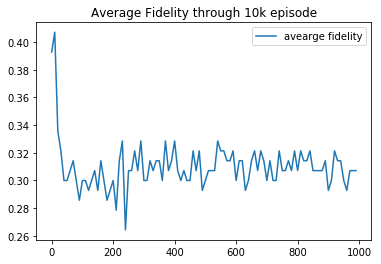

In [14]:
import matplotlib.pyplot as plt

plt.plot(x, f_mean[: : 10], label='avearge fidelity')
plt.title('Average Fidelity through 10k episode')
plt.legend()
plt.show()

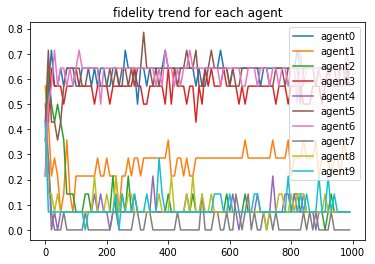

In [15]:
for i in range(10):
    plt.plot(x, f[i][: : 10], label='agent'+str(i))
plt.legend()
plt.title('fidelity trend for each agent')
plt.show()


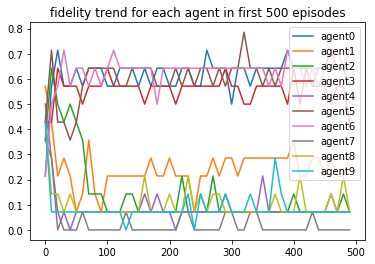

In [16]:
x_sub = np.arange(0, 500, 10)
for i in range(10):
    plt.plot(x_sub, f[i][: 500: 10], label='agent'+str(i))
plt.legend()
plt.title('fidelity trend for each agent in first 500 episodes')
plt.show()


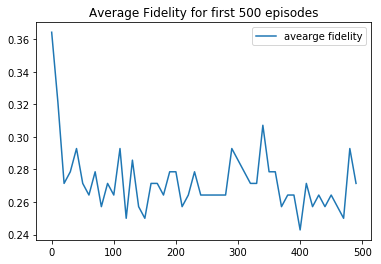

In [64]:
import matplotlib.pyplot as plt

plt.plot(x_sub, f_mean[: 500: 10], label='avearge fidelity')
plt.title('Average Fidelity for first 500 episodes')
plt.legend()
plt.show()

In [49]:
f[1].shape

(10000,)

In [57]:
env.render()

R O O O O 

O X W O O 

O O P O O 



In [24]:
FIDELITY_MATRIX.shape

AttributeError: ignored

In [0]:
np.argmax([np.nan, np.nan])

In [0]:
env.A[4]